# Introduction

Happiness is a concept that is hard to explain and, until recently, many would say it was even harder to measure. But researchers have come up with tools for measuring happiness with various approaches such as: biological, behavioral, implicit measures, other reports (asking others) and self reports [Mark Holder(2017)].

Questionnaires and surveys have been made available by the scientific community to measure happiness on a scale that can be understood and utilized in future studies and decision makings. Some examples are:
- [Subjective Happiness Scale](http://sonjalyubomirsky.com/subjective-happiness-scale-shs/) [Wright(2008)]
- [Oxford Happiness Inventory](http://www.meaningandhappiness.com/oxford-happiness-questionnaire/214/) [Lyubomirsky(1999)] 

These questionnairs and surveys use a number of attribues which use well-being, inequality, economy and affects of social environment for measuring the elusive concept of happiness. Critisism and academic debate goes on on the correlation of some attributes and procedures of measuring the happiness but no one can impute that given the tools these are some of the best ways to measure subjective welfare of a country or a person.   

In this notebook we have used data from [World Happiness Report](https://worldhappiness.report/ "WHR") for assessment, modeling and prediction using machine learning techniques. WHR uses the [Gallup World Poll](https://www.gallup.com/analytics/232838/world-poll.aspx) for data collection. The World Happiness Report 2020 is their eighth and latest report. It delves into the attributes that contribute to the level of a person's (country's) happiness. 

The WHR20 has data from years 2005-2019 from 166 countries. 

## Problem Statement
Given the multiple attributes about a country, train a model to predict the happiness score. To accomplish this we will try unsupervised and supervised machine learning algorithms on the data and study the results and comparisons to conclude which model works best with our data for predicting happiness. 

## Methodology
1. **Explore Dataset**: 
    First we will import the dataset/report from [World Happiness Report](https://worldhappiness.report/ "WHR")  and explore the dataset structure and attributes. We study what the attribute values mean and if they are relevant to our analysis. We then discard the irrelevant attributes and deal with missing data by imputing it. 

2. **Visualization**: 
    To make sense of the dataset we visualize the data to learn reasonable information from raw data. 

3. **Feature Selection**: Before further delving into supervised and unsupervised learning, we perform feature selection to choose the best subset of features as input for our models.

4. **Train/Test Split**: We split out data into training and testing dataset with 70% and 30% ratio respectively. 

5. **Cluster Analysis**: Clustering is performed to study the patterns in the data.

6. **Regression Analysis**: Because out target data is happiness score and it is a continuous variable, regression is performed instead of classification. We use multiple regression models on out data to study which performs best. 

7. **Comparison**: We compare the results of various models of regression 

8. **Conclusions & Future Work**: Taking into account all the analysis models, visualization and comparison we draw conclusions and discuss additional features and analysis that could be performed/added for future work. 

### Library Imports

In [1]:
from time import time
import numpy as np
import pandas as pd
import os
#For visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.gridspec as gridspec 
#For preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from impyute.imputation.cs import mice
#For modeling
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

start = time()

### Method for Evaluating the Models

In [2]:
performance_metrics = [['MAE', 'MSE', 'RMSE', 'R2']]

def analysis_score(y_test, y_predicted):
    mae = mean_absolute_error(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
    r2 = r2_score(y_test, y_predicted)

    print("The model performance for testing set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    
    performance_metrics.append([round(mae, 2),
                                round(mse, 2),
                                round(rmse, 2),
                                round(r2, 2)])
   

# Dataset

The data comes in form of an Excel file. A single record in the original dataset consists of identification labels (Country and Year), a continuous value of happiness score (treated further as a response variable) and a series of numerical values corresponding to economical and social attributes. To enrich the data visualisation part of the report and look for potential patterns in the data we created an additional column by assigning a 'Region' label to each observation, based on geographical location of the country.

Below we take a closer look at how the variables are definied and how they were calculated:

- Happiness score - originally named 'Life Ladder' - is a response to the question asked in street polls during several releases of the Gallup World Poll (GWP), averaged on the country level. Respondents were asked to place themselves on a ladder step from 0 to 10, where 0 meant they were at that moment living the worst possible life they could imagine for themselves and 10 meant the best possible life they could imagine.
- GDP per capita - gross domestic product in purchasing power parity (PPP).
- Social support - measure of people's binary reponses whether or not they have someone among family or friends they can count on when they need help.
- Healthy Life Expectancy - estimates of the World Health Organisation.
- Freedom to make life choices - average score obtained from the GWP question about the level of freedom when choosing what to do with one's life.
- Generosity - measure of how generously people donate to charities scaled by GDP per capita.
- Trust - measure of people's beliefs regarding the spread of corruption in the government and business circles.
- Positive affect - measure of how often people laugh and experience the feeling of happiness and enjoyment.
- Negative effect - measure of how often people worry and experience the feeling of sadness and anger.
- Democratic quality - measure of a degree to which citizens participate in the process of selecting goverment, as well as reflection of freedom of expression, association and political stability.
- Delivery quality - measure of government effectiveness, corruption control and regulatory quality.
- Gini index of household income reported in GWP - economical variable based on the household income reported by respondents.
- Gini index from the World Bank - economical factor calculated from the data gathered by governmental agencies and World Bank country departments.

In [3]:
df = pd.read_excel('WHR20.xls').round(3)     #Rounding off the decimal values till 3 decimal places
df.groupby(['year', 'Region']).first()

Country name  Life Ladder  \
year Region                                                         
2005 Australia and New Zealand             Australia        7.341   
     Central and Eastern Europe       Czech Republic        6.439   
     Eastern Asia                              Japan        6.516   
     Latin America and Caribbean              Brazil        6.637   
     Middle East and Northern Africa           Egypt        5.168   
...                                              ...          ...   
2019 North America                            Canada        7.109   
     Southeastern Asia                      Cambodia        4.998   
     Southern Asia                       Afghanistan        2.375   
     Sub-Saharan Africa                        Benin        4.976   
     Western Europe                          Austria        7.195   

                                      Log GDP per capita  Social support  \
year Region                                                                
2005 Australia and New Zealand                    10.571           0.968   
     Central and Eastern Europe                   10.157           0.919   
     Eastern Asia                                 10.482           0.928   
     Latin America and Caribbean                   9.422           0.883   
     Middle East and Northern Africa               9.004           0.848   
...                                                  ...             ...   
2019 North America                                10.694           0.925   
     Southeastern Asia                             8.315           0.759   
     Southern Asia                                 7.458           0.420   
     Sub-Saharan Africa                            7.711           0.442   
     Western Europe                               10.756           0.964   

                                      Healthy life expectancy at birth  \
year Region                                                              
2005 Australia and New Zealand                                    71.4   
     Central and Eastern Europe                                   67.0   
     Eastern Asia                                                 73.2   
     Latin America and Caribbean                                  63.3   
     Middle East and Northern Africa                              59.7   
...                                                                ...   
2019 North America                                                73.8   
     Southeastern Asia                                            62.0   
     Southern Asia                                                52.4   
     Sub-Saharan Africa                                           54.7   
     Western Europe                                               73.3   

                                      Freedom to make life choices  \
year Region                                                          
2005 Australia and New Zealand                               0.935   
     Central and Eastern Europe                              0.865   
     Eastern Asia                                            0.868   
     Latin America and Caribbean                             0.882   
     Middle East and Northern Africa                         0.817   
...                                                            ...   
2019 North America                                           0.912   
     Southeastern Asia                                       0.957   
     Southern Asia                                           0.394   
     Sub-Saharan Africa                                      0.770   
     Western Europe                                          0.903   

                                      Generosity  Perceptions of corruption  \
year Region                                                                   
2005 Australia and New Zealand               NaN                      0.390   
     Central and Eastern Europe           

In [4]:
# print(df.groupby(['year','Region']).first().to_latex())

## Data Cleaning

Clean and short data is better than longer and unclean data. Taking time out to clean the data pays off in other phases of the project. 

The first step is to get rid of duplicates and irrelevant data. WHR dataset does not contain duplicate values. As for irrelevant values - its subjective. We will drop the columns whose values are derived from other columns or collected with uncertain collection methods. 


In [5]:
df = df.drop(columns=[
    'Confidence in national government',
    'Standard deviation of ladder by country-year',
    'Standard deviation/Mean of ladder by country-year',
    'GINI index (World Bank estimate)',
    'GINI index (World Bank estimate), average 2000-2017, unbalanced panel',
    'gini of household income reported in Gallup, by wp5-year'
])

Next step is to handle missing data. First we'll check how many missing values are we dealing with in each column. To do this we are using the pandas method isnull(). This method returns true for every missing, null or NaN value. 

In [6]:
df.isnull().sum()

Country name                                          0
Region                                                0
year                                                  0
Life Ladder                                           0
Log GDP per capita                                   29
Social support                                       13
Healthy life expectancy at birth                     52
Freedom to make life choices                         31
Generosity                                           83
Perceptions of corruption                           103
Positive affect                                      21
Negative affect                                      15
Democratic Quality                                  149
Delivery Quality                                    148
Most people can be trusted, Gallup                 1668
Most people can be trusted, WVS round 1981-1984    1712
Most people can be trusted, WVS round 1989-1993    1611
Most people can be trusted, WVS round 1994-1998 

Dropping columns that are mostly empty and renaming other columns. We are left with 10 feature columns in addition to year, country, region and happiness score.

In [7]:
df = df.drop(columns=['Most people can be trusted, Gallup', 
                      'Most people can be trusted, WVS round 1981-1984',
                      'Most people can be trusted, WVS round 1989-1993',
                      'Most people can be trusted, WVS round 1994-1998',
                      'Most people can be trusted, WVS round 1999-2004',
                      'Most people can be trusted, WVS round 2005-2009',
                      'Most people can be trusted, WVS round 2010-2014'])

df.rename(columns = {'Country name' : 'Country',
                     'year' : 'Year',
                     'Life Ladder' : 'Happiness Score',
                     'Log GDP per capita' : 'Economy',
                     'Social support' : 'Social Support',
                     'Freedom to make life choices' : 'Freedom',
                     'Healthy life expectancy at birth' : 'Life Expectancy',
                     'Perceptions of corruption' : 'Trust'}, 
          inplace = True)

featurevector = ['Economy', 'Social Support', 'Life Expectancy', 'Freedom', 'Generosity', 'Trust',
                 'Positive affect', 'Negative affect', 'Democratic Quality','Delivery Quality']

**Imputing Missing Values**

Filling in the missing data using mean of the values of the country as opposed to mean of the whole column. This will give us more relevant data. 

After that if we are still left with some missing values we impute those values using MICE (MultiVariate Imputation by Chained Equation) algorithm. MICE takes all features as potentially connected forming chained equation and having the best fit for missing values so that the chained equation would have least error in Linear regression.

In [8]:
# Taking mean of the data to fill the missing values
for column in featurevector:
    df[column] = df.groupby('Country')[column].transform(lambda grp: grp.fillna(np.mean(grp))) 

    
#Using MICE algorithm to fill the missing data
finding=np.array(df.values[:,3:],dtype=float)
interpolated = mice(finding)
ctr=1
for column in featurevector:
    df[column]=df[column].replace(df.values[:,ctr+3],interpolated[:,ctr])
    ctr+=1

## Visualizing the Data

Graphs and visualizations provide us with more cohesive picture as opposed to a large dataset with raw values. To understand our data and learn patterns and trends, we produce various graphs from our data.



Before we proceed with visualization with various graphs, we scale the column values, because some columns have varying ranges. For our visualizations we have mainly used data from just one year (latest: 2019).

In [9]:
df1 = df
min_max_scaler = preprocessing.MinMaxScaler()
df1[featurevector] = min_max_scaler.fit_transform(df1[featurevector])

whr = df1.groupby('Year')
data2017 = whr.get_group(2017)
data2018 = whr.get_group(2018)
data2019 = whr.get_group(2019)

data2017 = data2017.sort_values(by=['Happiness Score'], ascending=False);
data2018 = data2018.sort_values(by=['Happiness Score'], ascending=False);
data2019 = data2019.sort_values(by=['Happiness Score'], ascending=False);

### Number of Countries According to the Region (2019)

We check how many countries are participating in the dataset and which region they belong to. 

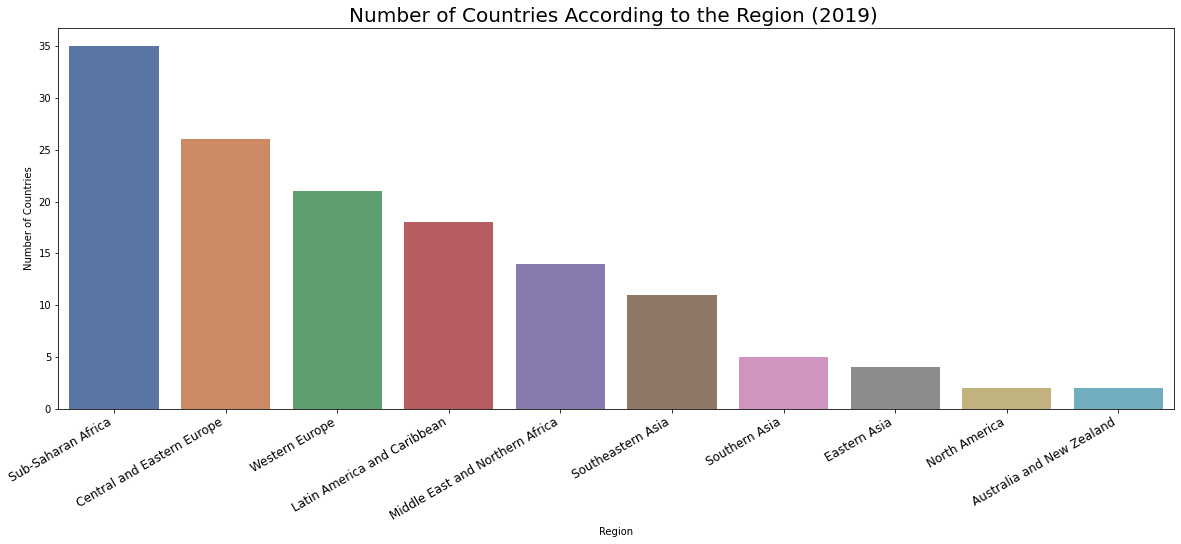

In [10]:
dt2019 = data2019.Region.value_counts()
plt.figure(figsize=(20,7))
sns.barplot(x = dt2019.index, y = dt2019.values, palette="deep")
plt.xlabel('Region')
plt.xticks(rotation = 30,fontweight=50,horizontalalignment='right',fontsize=12)
plt.ylabel('Number of Countries')
plt.title('Number of Countries According to the Region (2019) ', color = 'black', fontsize = 20)
plt.show()

### Countries' Happiness Score According to the Region (2019)

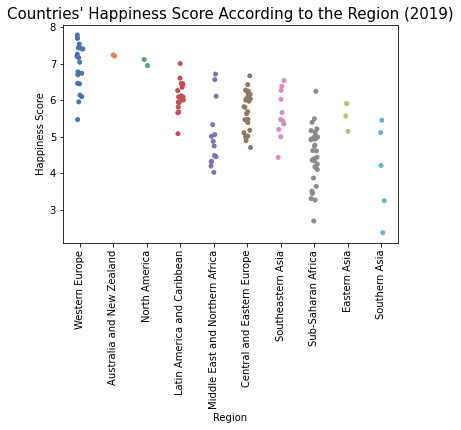

In [11]:
sns.stripplot(x = "Region", y = "Happiness Score", data = data2019, jitter = True, palette="deep")
plt.xticks(rotation = 90)
plt.title("Countries' Happiness Score According to the Region (2019)", color = 'black', fontsize = 15)
plt.show()

### Number of Countries based on Happiness Score Average (2019)

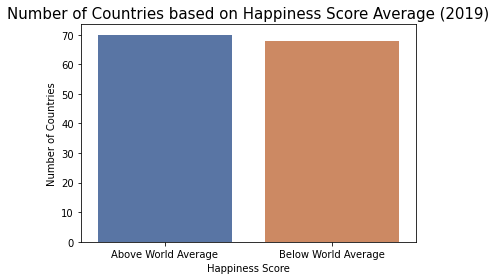

In [12]:
above_mean_HS =['Above World Average' if i >= data2019.mean()['Happiness Score'] else 'Below World Average' for i in data2019['Happiness Score']]
df1 = pd.DataFrame({'HappinessScore' : above_mean_HS})
sns.countplot(x = df1['HappinessScore'], palette="deep")
plt.xlabel('Happiness Score')
plt.ylabel('Number of Countries')
plt.title('Number of Countries based on Happiness Score Average (2019)',  fontsize = 15)
plt.show()

### Economic Situations vs Government Corruption Index of the Countries

In [13]:
trace1 = go.Box(
    y = data2019.Economy,
    name = 'Economic Situations of Countries in 2019',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)
trace2 = go.Box(
    y = data2019.Trust,
    name = 'Government Corruption Index in 2019',
    marker = dict(
        color = 'rgb(12, 128, 128)',
    )
)
data = [trace1, trace2]
iplot(data)

### Top 3 Countries in 2017 According to the Different Parameters

In [14]:
df2019 = data2019.iloc[:3, :]


trace1 = go.Bar(x = df2019.Country,
                y = df2019.Economy,
                name = "Economy")
trace2 = go.Bar(x = df2019.Country,
                y = df2019['Social Support'],
                name = "Social support")
trace3 = go.Bar(x = df2019.Country,
                y = df2019['Life Expectancy'],
                name = "Life expectancy")
trace4 = go.Bar(x = df2019.Country,
                y = df2019.Trust,
                name = "Trust")
trace5 = go.Bar(x = df2019.Country,
                y = df2019.Generosity,
                name = "Generosity")
trace6 = go.Bar(x = df2019.Country,
                y = df2019.Freedom,
                name = "Freedom")

data = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = go.Layout(barmode = 'group', title = 'Top 3 Countries in 2017 According to the Different Parameters')
fig = go.Figure(data = data, layout = layout)
iplot(fig)
plt.show()

### Life Expectancy Trend of Most and Least Happiest Countries

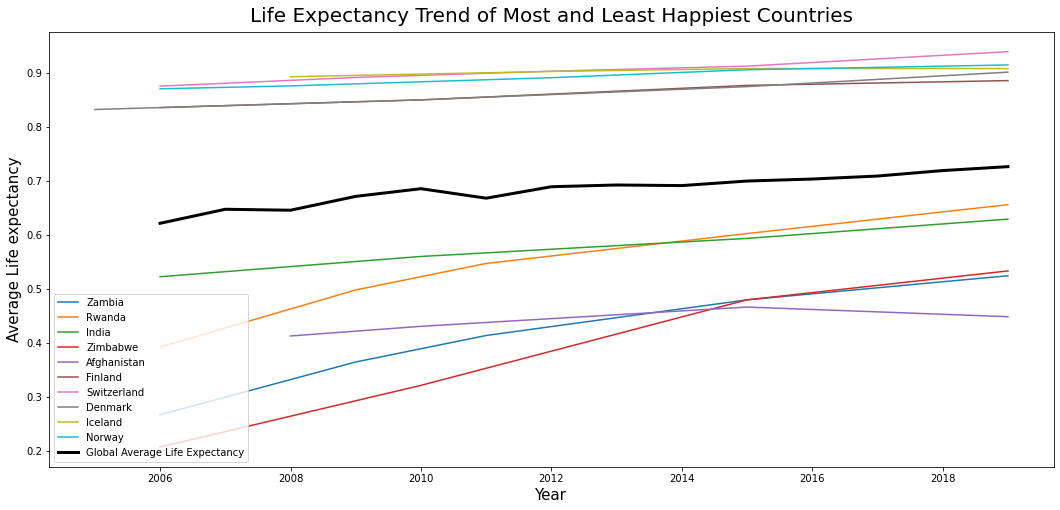

In [15]:
countries = data2019.values[-5:, 0]
countries = np.append(countries, data2019.values[:5, 0])
plt.figure(figsize=(18, 8))
for country in countries:
    plt.plot(df['Year'].loc[df['Country'] == country],
             df['Life Expectancy'].loc[df['Country'] == country],
             label=country,
             linewidth=1.5)
global_mean = df.groupby(['Year'])['Life Expectancy'].mean()
plt.plot(global_mean[1:][:],
         color='black',
         linewidth=3,
         label='Global Average Life Expectancy')
plt.legend(loc=3)
plt.title('Life Expectancy Trend of Most and Least Happiest Countries',
          fontsize=20,
          pad=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average Life expectancy', fontsize=15)
plt.show()

### Happiness Score vs Economy

In [16]:
fig = px.scatter(data2019, x='Happiness Score', y='Economy', text='Country')
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, title="Happiness Score vs Economy")
fig.show()

###  Features Relationships

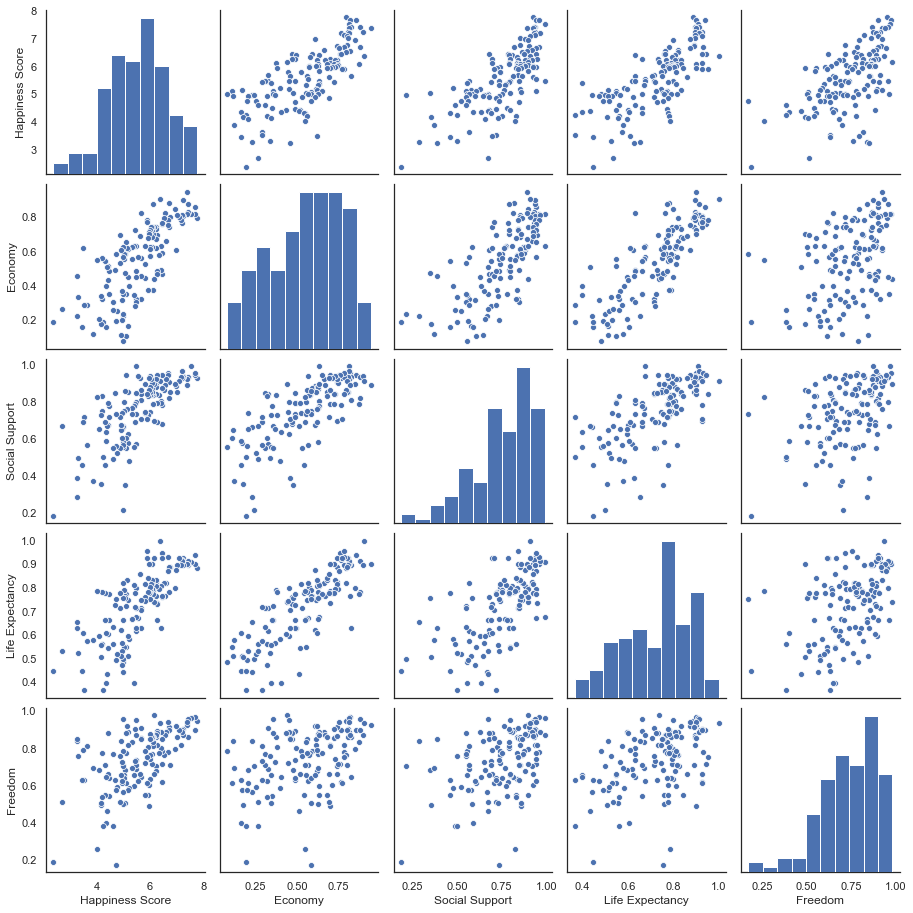

In [17]:
sns.set(style="white", font_scale=1)
sns.pairplot(data2019[['Happiness Score', 'Economy', 'Social Support', 'Life Expectancy','Freedom']])
plt.show()

### Global Happiness 2019

In [18]:
data = dict(type='choropleth',
            locations=data2019['Country'],
            locationmode='country names',
            z=data2019['Happiness Score'],
            text=data2019['Country'],
            colorbar={'title': 'Happiness'})
layout = dict(title='Global Happiness 2019', geo=dict(showframe=True, ))
choromap3 = go.Figure(data=[data], layout=layout)
iplot(choromap3)

### Happiness Shift

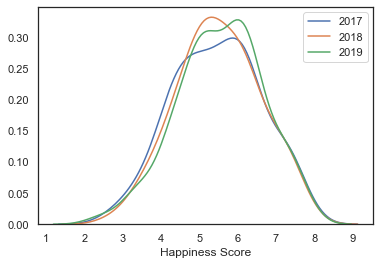

In [19]:
sns.kdeplot(data2017['Happiness Score'], label='2017')
sns.kdeplot(data2018['Happiness Score'], label='2018')
sns.kdeplot(data2019['Happiness Score'], label='2019')
plt.xlabel('Happiness Score');

The above plot shows a slightly more happier world in 2019. 

# Feature Selection

When faced with multiple features it is a good practice to scale them down to features that give us the best result when used as input in our models. Feature selection is selecting a subset of features that most affect our model.Identifying these features is as important as modeling itself. Feature selection is uselful in reducing the computational time also. 

We have used PCA for analysis and dimentionality reduction and Pearsons' correlation for feature selection. 

**Splitting dataset into train and test datasets**


For modeling we have split the data into train and test splits with 70% and 30% respectively. This split ensures we have separate data for testing as well as lowers the occurence of overtraining. We have also scaled our test and train split using standard scalar. 


In [21]:
target = 'Happiness Score'

X = df[featurevector].values
y = df[target].values

# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=df.Region.values)

In [22]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## PCA

To get an overview of the dataset we performed Principal Component Analysis (PCA). The purpose of using this unsupervised technique was to recognize the dataset, identify most informative features and, potentially, reduce the dimensionality of the dataset.

To start with, we plotted 9 original variables against each other, in all possible combinations, as presented
in the matrix below. Datapoints are colored by the value of the Y response - the Happiness Score. Our data do not have labels, so we can only try to discover unknown patterns. A few observations can be made at this point:
- there is a positive correlation between certain pairs of variables, e.x. Economy vs. Social support, Economy vs. Life expectancy
- vague outlines of the same-color clusters are visible on the charts mentioned above.

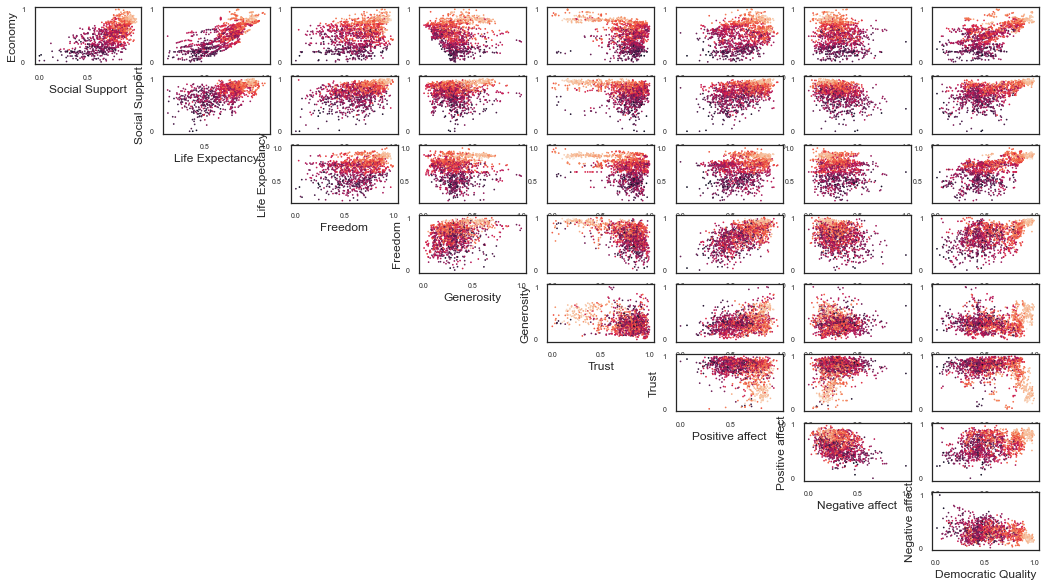

In [23]:
gs = gridspec.GridSpec(8, 8)
plt.figure(figsize=(18,10))
for ny in range(8):
    for nx in range(ny+1, 9):
        plt.subplot(gs[ny, nx-1])
        plt.scatter(X_train[:, nx], X_train[:, ny], c=y_train, s=.5)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7);
        if ny == nx-1:
            plt.xlabel(featurevector[nx])
            plt.ylabel(featurevector[ny])
plt.show()

Moving on to the PCA itself, we calculated and plotted the proporition of variance corresponding to 10 subsequent principal components, also in the form of cumulated variance per PC. We can see that there is no clear threshold above which the contribution of PCs drops drastically. That means there is no clear indication how many PCs are of a big importance and where we can cut off the redundant 'tail'.

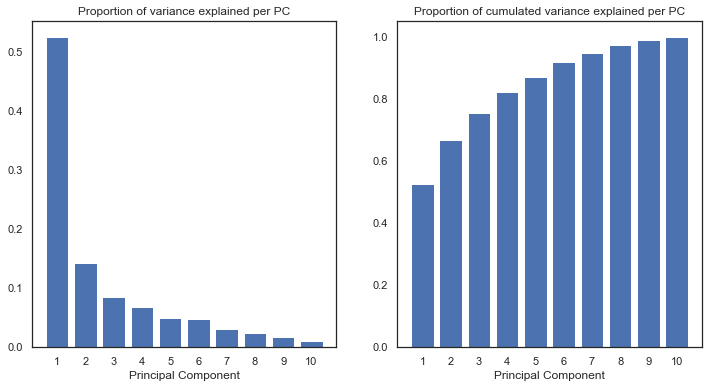

In [24]:
pca = PCA()

# Fit a model to the training data; unsupervised---no labels needed
X_train_PCA = pca.fit_transform(X_train)

# Plot explained variance 
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.bar(range(1, 11), pca.explained_variance_ratio_)
plt.title('Proportion of variance explained per PC')
plt.xlabel('Principal Component')
plt.xticks(range(1, 11));

# Plot cumulated variance explained
plt.subplot(1, 2, 2)
plt.bar(range(1, 11), pca.explained_variance_ratio_.cumsum())
plt.title('Proportion of cumulated variance explained per PC')
plt.xlabel('Principal Component')
plt.xticks(range(1, 11))
plt.show()

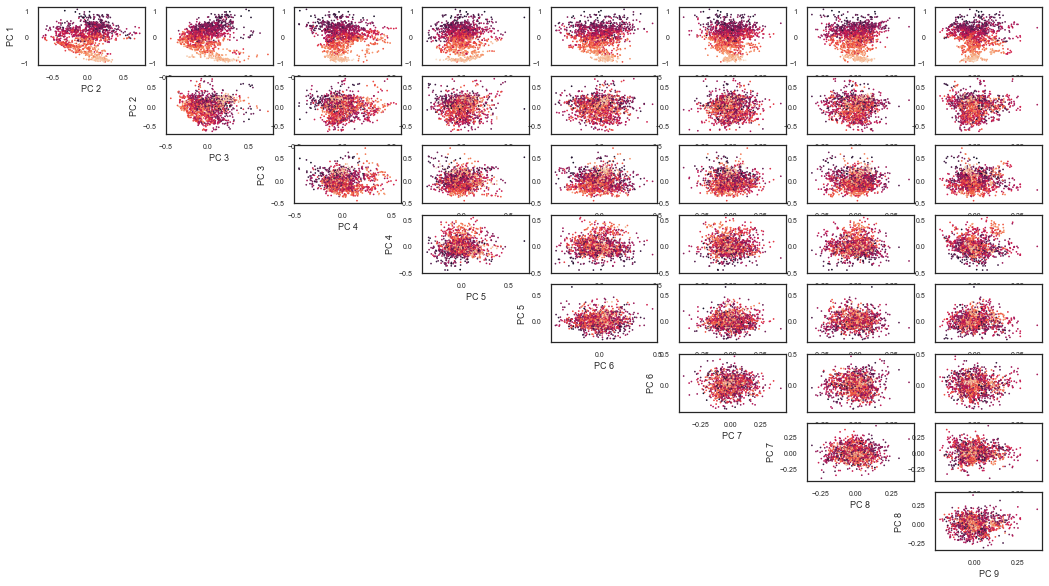

In [25]:
plt.figure(figsize=(18,10))
for ny in range(8):
    for nx in range(ny+1, 9):
        plt.subplot(gs[ny, nx-1])
        plt.scatter(X_train_PCA[:, nx], X_train_PCA[:, ny], c=y_train, s=0.5)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7);
        if ny == nx-1:
            plt.xlabel('PC {}'.format(nx+1), fontsize=9)
            plt.ylabel('PC {}'.format(ny+1), fontsize=9)
plt.show()

## Pearson Correlation

For regression problems Pearson correlation is the most common method used. It gives results between -1 and 1, -1 meaning the relationship is weakest and +1 represents strongest relationship. We have shown these relations between features in the correlation matrix below.  

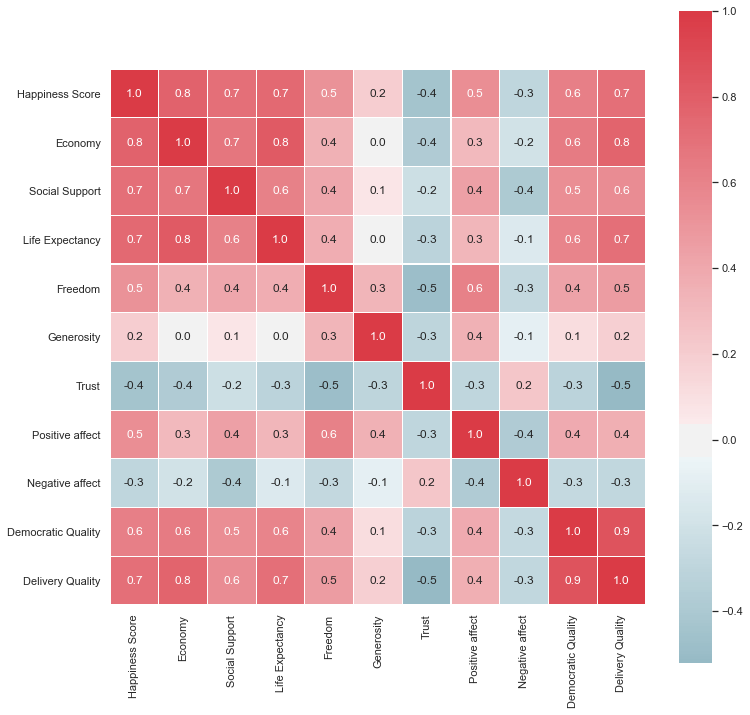

In [26]:
#Using Pearson Correlation
fv = ['Happiness Score','Economy', 'Social Support', 'Life Expectancy', 'Freedom', 'Generosity', 'Trust', 'Positive affect', 'Negative affect', 'Democratic Quality', 'Delivery Quality']
df_correl = df[fv]
f,ax = plt.subplots(figsize = (12, 12))
sns.heatmap(df_correl.corr(), annot = True, linewidths = 0.1, fmt = '.1f', ax = ax, square = True,center=0,  cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

In [27]:
#Correlation with output variable
cor = df_correl.corr()
cor_target = abs(cor["Happiness Score"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

Happiness Score       1.000000
Economy               0.776609
Social Support        0.704695
Life Expectancy       0.740012
Freedom               0.517398
Positive affect       0.538006
Democratic Quality    0.623857
Delivery Quality      0.708137
Name: Happiness Score, dtype: float64

Splitting into train and test and scaling one again with only relevant features selected. 

In [28]:
filtered_features =  ['Economy', 'Social Support', 'Life Expectancy', 'Freedom', 
                      'Positive affect', 'Democratic Quality','Delivery Quality']
X_filtered = df[filtered_features].values
y_filtered = df[target].values

# Split the data into training and test data
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, 
                                                    random_state=1, stratify=df.Region.values)

sc.fit(X_train_filtered)
X_train_std_filtered = sc.transform(X_train_filtered)
X_test_std_filtered = sc.transform(X_test_filtered)

# Unsupervised Learning: Cluster Analysis

Unsupervised learning techniques can bring insights into the nature and patterns existing in the data. Clustering is one such method. By including an arbitrary set of X variables and plotting them in the multidimensional space we can discover similarities between groups of datapoints and thus draw conclusions.

We chose to use a centroid-based clustering method called k-means clustering. This method requires specifying the number of clusters (k). The algorithm then segregates the data into these k clusters under the assumption that each observation falls into the cluster with the nearest mean value. In the next step the algorithm re-stimates cluster centers to better fit to the assigned datapoint groups. Last two steps are repeated iteratively, until the convergence criterion is met.

We ran the clustering code for the number of clusters ranging from 2 to 10, plotted the results in the Happiness vs. Economy space and we observed that the best result (best separation of color-coded datapoints) could be observed for three clusters.

In [60]:
n_clusters = 3
KM = KMeans(n_clusters,  
            init='random', 
            n_init=20,     
            max_iter=300,
            tol=1e-04,  
            random_state=0)

sc.fit(X_filtered)
X_std = sc.transform(X_filtered)

groupsKM = KM.fit_predict(X_std)

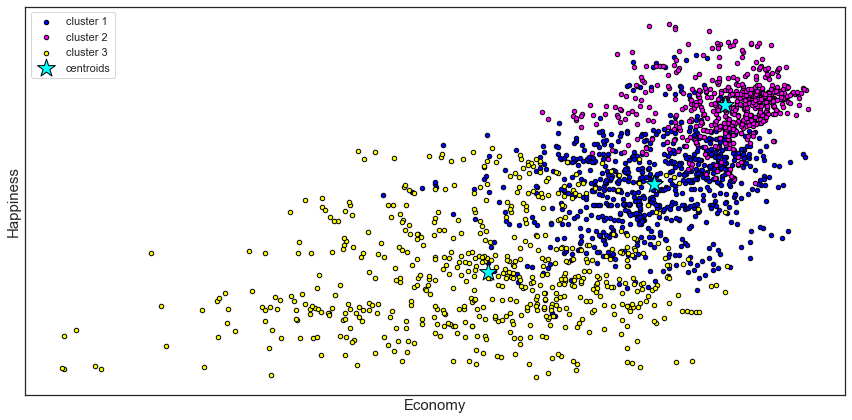

In [68]:
plt_col = ['blue','magenta','yellow', 'green', 'red', 'pink',  'black', 'orange', 'brown']
plt.figure(figsize=(12,6))
for k in range(n_clusters):
    plt.scatter(X_std[groupsKM == k, 1],
                X_std[groupsKM == k, 0],
                s=20, c=plt_col[k],
                marker='o', edgecolor='black',
                label='cluster {}'.format(k+1))

plt.scatter(KM.cluster_centers_[:, 1],
            KM.cluster_centers_[:, 0],
            s=350, marker='*',
            c='cyan', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.xlabel("Economy", fontsize=15)
plt.ylabel("Happiness", fontsize=15)
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
plt.tight_layout()
plt.show()

Trying to interpret the meaning of three clusters we plotted a stacked bar chart to see whether any conclusions about geographical location of the datapoints falling into each cluster can be drawn.

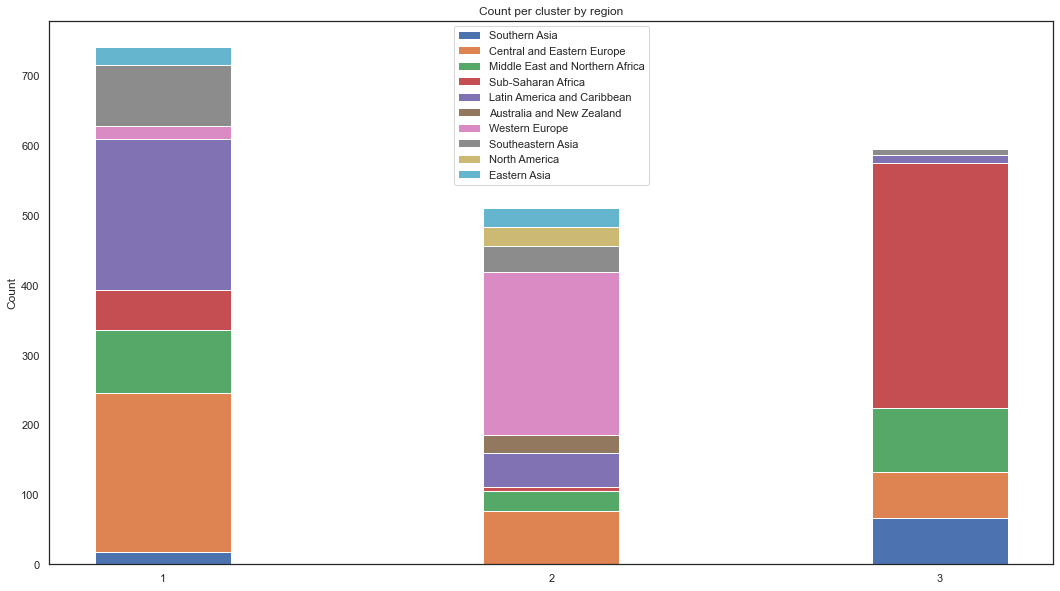

In [62]:
cum_arr = []
for i in df.Region.unique():
    part_arr = []
    for j in range(n_clusters):
        part_arr.append(df[groupsKM == j].loc[df['Region'] == i].shape[0])
    cum_arr.append(part_arr)
#print(sum(sum(x) for x in cum_arr))

reg0 = np.array(cum_arr[0])
reg1 = np.array(cum_arr[1])
reg2 = np.array(cum_arr[2])
reg3 = np.array(cum_arr[3])
reg4 = np.array(cum_arr[4])
reg5 = np.array(cum_arr[5])
reg6 = np.array(cum_arr[6])
reg7 = np.array(cum_arr[7])
reg8 = np.array(cum_arr[8])
reg9 = np.array(cum_arr[9])

labels = [str(i) for i in range(1,n_clusters+1)]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(18,10))

ax.bar(labels, reg0, width, label='Southern Asia')
ax.bar(labels, reg1, width, label='Central and Eastern Europe', bottom=reg0)
ax.bar(labels, reg2, width, label='Middle East and Northern Africa', bottom=reg0+reg1)
ax.bar(labels, reg3, width, label='Sub-Saharan Africa', bottom=reg0+reg1+reg2)
ax.bar(labels, reg4, width, label='Latin America and Caribbean', bottom=reg0+reg1+reg2+reg3)
ax.bar(labels, reg5, width, label='Australia and New Zealand', bottom=reg0+reg1+reg2+reg3+reg4)
ax.bar(labels, reg6, width, label='Western Europe', bottom=reg0+reg1+reg2+reg3+reg4+reg5)
ax.bar(labels, reg7, width, label='Southeastern Asia', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6)
ax.bar(labels, reg8, width, label='North America', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6+reg7)
ax.bar(labels, reg9, width, label='Eastern Asia', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6+reg7+reg8)


ax.set_ylabel('Count')
ax.set_title('Count per cluster by region')
ax.legend()

plt.show()

At first it is hard to find a pattern, as many of colors correponding to world regions are spread across more than one cluster. However, after a closer look we have made a couple of observations:

- most of Western Europe, North America and Australia & New Zealand fall into one cluster
- Latin America & Carribean and Sub-Saharan Africa are very uniform - almost all datapoints were assigned to one cluster
- Southeastern Asia is spread across all three clusters, which can reflect inequalities amongst countries in this region of the world.

In [65]:
data = [dict(type='choropleth',
             locations = data2019['Country'],
             locationmode = 'country names',
             z = groupsKM,
             text = data2019['Country'],
             colorbar = {'title':'Cluster Group'})]
layout = dict(title='Clustering of Countries based on K-Means',
              geo=dict(showframe = False))
map1 = go.Figure(data = data, layout=layout)
iplot(map1)

# Supervised Learning: Regression Analysis

Supervised learning is when we have a target variable/class what we want to predict given other attributes. Given that we have a continuous outcome variable (Happiness Score), we have employed different regression analysis types to establish the relationship between our features and outcomes which includes

1. Linear Regression
2. Support Vector Regression (SVR)
3. LASSO Regression
4. Elastic Net Regression
5. Decision Trees
6. Random Forest Regression
7. Principal Component Regression (PCR)


Performance parameters from each of these are compared at the end to find the the best fitting model for our dataset.

## Evaluation Metrics
For regression analysis the three most common used metrics are: 
- **MAE (Mean Absolute Error)** : According to [Brownlee(2016)] MAE is the average of the absolute differences between predictions and actual values. It gives an idea of how wrong the predictions were.
- **MSE (Mean Squared Error)**: MSE also gives error estimation. 
- **RMSE (Root Mean Squared Error)**: RMSE is square root of MSE. 
- **R2 (R squared)**: R2 is also called coefficient of determination. It is the same as accuracy. It tells us how well the models fits the data - i.e. "provides an indication of the goodness of fit of a set of predictions to the actual values"  [Brownlee(2016)].

## Linearity Test


Before we start, it's important to check if our dataset fulfils the statistical assumptions for regression analysis. We have already verified multicollinearity in the previous sections and found no discrepancies as the Pearson Correlation heatmap of filtered features shows independent variables to be totally non-correlated with each other, hence fulfilling the requirement. Next step is to find if the relationship between our dependent and independent variables is linear, for which we have to perform the Linearity Test. 

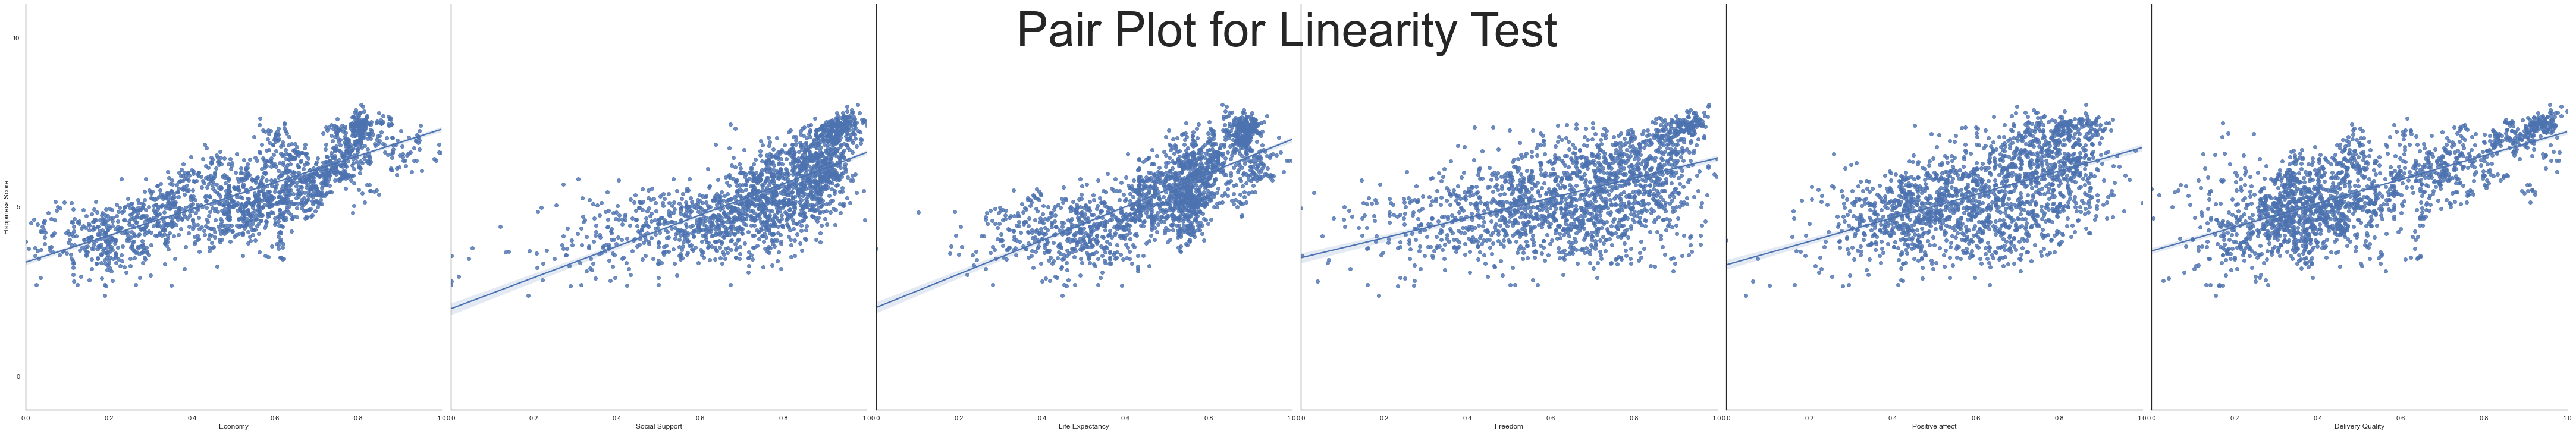

In [32]:
g = sns.PairGrid(df, y_vars=["Happiness Score"], x_vars=['Economy', 'Social Support', 'Life Expectancy',
       'Freedom', 'Positive affect', 'Delivery Quality'], height=10)
g.map(sns.regplot)
g.set(ylim=(-1, 11), yticks=[0, 5, 10])
plt.suptitle('Pair Plot for Linearity Test', size = 80);

plt.show()

All selected features depict a liner relation with the outcome 'Happiness Score', as we see an even spread of data along diagonal line.

## Linear Regression

Linear regression is one of the most commonly used regression techniques, particularly when the relationship between features and outcomes is linear.

"Linear regression calculates the estimators of the regression coefficients or simply the predicted weights, denoted with 𝑏₀, 𝑏₁, …, 𝑏ᵣ. They define the estimated regression function 𝑓(𝐱) = 𝑏₀ + 𝑏₁𝑥₁ + ⋯ + 𝑏ᵣ𝑥ᵣ. This function should capture the dependencies between the inputs and output sufficiently well." [Stojiljkovi ́c(2016)]

In [33]:
linR = LinearRegression()
linR.fit(X_train_std_filtered, y_train_filtered)
y_pred_linR = linR.predict(X_test_std_filtered)

In [34]:
analysis_score(y_test_filtered,y_pred_linR)

The model performance for testing set
--------------------------------------
MAE is 0.4436176005175508
MSE is 0.3227342921426216
RMSE is 0.5680970798575026
R2 score is 0.7490817012886966


## Support Vector Regression

Support Vector Regression works on the same principles as of SVM, as it tries to find the best fit hyperplane which has maximum number of data points within the decision boundary. 

We trained the SVR based on standarized dataset and the prediction gave us the highest R^2 value (~0.83) out of all other methods with a MSE of ~0.21.

In [35]:
svr = SVR()
svr.fit(X_train_std_filtered, y_train_filtered)
y_pred_svr = svr.predict(X_test_std_filtered)

In [36]:
analysis_score(y_test_filtered,y_pred_svr)

The model performance for testing set
--------------------------------------
MAE is 0.3573840220808321
MSE is 0.2167858789073193
RMSE is 0.46560270500429796
R2 score is 0.831454093214176


## Least Absolute Shrinkage and Selection Operator (LASSO)

LASSO is a type of Linear Regression that performs L1 regularization which forces the sum of absolute values of the regression coefficients to be less than a fixed value. Since it uses the sum of absolute values, it forces certain coefficients to be set to zero and eliminated from model, hence making it more interpretable. (Add lecture citaion here)

In [37]:
lasso = Lasso(alpha=0.1, max_iter = 10000)  
lasso.fit(X_train_std_filtered, y_train_filtered)
y_pred_train_Lasso  = lasso.predict(X_train_std_filtered)
y_pred_test_Lasso  = lasso.predict(X_test_std_filtered)

In [38]:
analysis_score(y_test_filtered,y_pred_test_Lasso)

The model performance for testing set
--------------------------------------
MAE is 0.46744973374051296
MSE is 0.3416801665528363
RMSE is 0.5845341448990267
R2 score is 0.7343517308754246


## Elastic Net

Elastic net combines both Ridge and LASSO penalties.


In [39]:
elnet = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter = 100)
elnet.fit(X_train_std_filtered, y_train_filtered)
y_pred_train_Elnet = elnet.predict(X_train_std_filtered)
y_pred_test_Elnet = elnet.predict(X_test_std_filtered)

In [40]:
analysis_score(y_test_filtered,y_pred_test_Elnet)

The model performance for testing set
--------------------------------------
MAE is 0.7284144490746405
MSE is 0.7947937055430614
RMSE is 0.8915120333136628
R2 score is 0.38206664343810426


## Decision Tree Regression

Decision tree is another regression method which builds regression model like a tree structure. At each node a decision is made until we reach the result. Unlike other training methods decision trees doesn't require standardized dataset.

Here we have created a decision tree of depth 5 for outcome prediction.

In [41]:
DTree = DecisionTreeRegressor(max_depth=5)
DTree.fit(X_train_std_filtered, y_train_filtered)
y_pred_train_DTree = DTree.predict(X_train_std_filtered)
y_pred_test_DTree = DTree.predict(X_test_std_filtered)

In [42]:
analysis_score(y_test_filtered,y_pred_test_DTree)

The model performance for testing set
--------------------------------------
MAE is 0.41249597773750324
MSE is 0.27841588708132015
RMSE is 0.5276512930727263
R2 score is 0.7835382157351563


## Random Forest Regression

In Random Forest regression, multiple decision trees are trained on separate sample datasets and then they are aggregated to determine the final output.

"Every decision tree has high variance, but when we combine all of them together in parallel then the resultant variance is low as each decision tree gets perfectly trained on that particular sample data and hence the output doesn’t depend on one decision tree but multiple decision trees." [Dutta(2020)]

In [43]:
RForest = RandomForestRegressor(max_depth=5)
RForest.fit(X_train_std_filtered, y_train_filtered)
y_pred_train_RForest = RForest.predict(X_train_std_filtered)
y_pred_test_RForest = RForest.predict(X_test_std_filtered)

In [44]:
analysis_score(y_test_filtered,y_pred_test_RForest)

The model performance for testing set
--------------------------------------
MAE is 0.376128896971748
MSE is 0.23194499730821172
RMSE is 0.4816066832055092
R2 score is 0.8196682362670802


## Principle Component Regression

Principle Component Regression is similar to Linear Regression, but we use principle components identified in PCA as input parameters instead of the actual data.

In [45]:
pca = PCA(n_components=6)  
X_train_pca = pca.fit_transform(X_train_std_filtered)
X_test_pca = pca.transform(X_test_std_filtered)

linRPCA = LinearRegression()
linRPCA = linRPCA.fit(X_train_pca, y_train)
y_pred_pca = linRPCA.predict(X_test_pca)

In [46]:
analysis_score(y_test_filtered,y_pred_pca)

The model performance for testing set
--------------------------------------
MAE is 0.44365593560308286
MSE is 0.32278732451578157
RMSE is 0.5681437533897399
R2 score is 0.7490404698696194


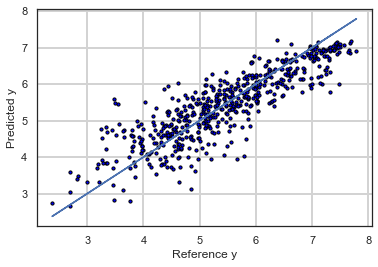

In [47]:
plt.scatter(y_test_filtered, y_pred_pca, c='blue', edgecolor='black', s=10)
plt.xlabel('Reference y')
plt.ylabel('Predicted y')
plt.plot(y_test_filtered, y_test_filtered)
plt.grid(color='LightGrey', linestyle='-', linewidth=2)
plt.show()

# Comparison & Conclusion

The barplots show the comparison between the regression models used. We have used Accuracy, Mean Squared Error and coeffiecient of determination as evaluation metrics. 

From the comparison we can see that SVR gives us the best performance with 84% accuracy (R2) and very low MSE and MAE values. The Elastic net results in the worst fitting with R2 score .38 and high error values.  

In [48]:
comparison = pd.DataFrame(data=performance_metrics[1:][:],
                          columns=performance_metrics[0],
                          index=['Linear Regression','SVR','LASSO','Elastic Net',
                                 'Decision Tree','Random Forest','PCR'])


trace2 = go.Bar(x = comparison.index,
                y = comparison.MAE,
                name = performance_metrics[0][0])
trace3 = go.Bar(x = comparison.index,
                y = comparison.MSE,
                name = performance_metrics[0][1])
trace4 = go.Bar(x = comparison.index,
                y = comparison.R2,
                name = performance_metrics[0][3])

data = [trace2,trace3,trace4]
layout = go.Layout(barmode = 'group', title = 'Comparison of Performance for different prediction models')
fig = go.Figure(data = data, layout = layout)
iplot(fig)

#print(time()-start)

# Bibliography

**[Mark Holder(2017)]**  Ph.D.  Mark  Holder.Measuring  happiness:   How  can  we  measure  it?,2017.URL https://www.psychologytoday.com/us/blog/the-happiness-doctor/201705/measuring-happiness-how-can-we-measure-it#:~:text=Self%2DReports.,to%20ask%20them%20about%20it.

**[Wright(2008)]**  Dr.  Steve  Wright. Oxford  happiness  questionnaire,  2008. URL http://www.meaningandhappiness.com/oxford-happiness-questionnaire/214/.

**[Lyubomirsky(1999)]** Lepper H Lyubomirsky, S.   Subjective happiness scale, 1999.   URL http://sonjalyubomirsky.com/subjective-happiness-scale-shs/.

**[Brownlee(2016)]**  Jason Brownlee. Metrics to evaluate machine learning algorithms in python, 2016. URL https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/.

**[Stojiljkovi ́c(2016)]**  Mirko  Stojiljkovi ́c.Linear  regression  in  python,   2016. URL https://realpython.com/linear-regression-in-python/.

**[Dutta(2020)]**  Avik  Dutta.Random  forest  regression  in  python,  2020. URL https://www.geeksforgeeks.org/random-forest-regression-in-python/.